TP PARTIE 1 — STATISTIQUES ET LOI NORMALE EN FINANCE
Analyse risque portefeuille et calcul VaR


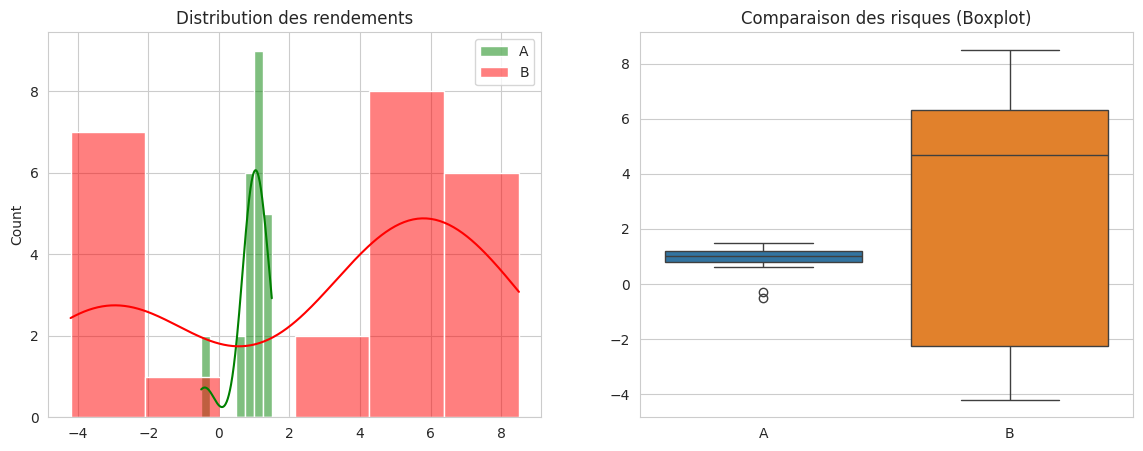

VaR Annuelle A: 45,649€ | Sharpe: 5.35
VaR Annuelle B: 77,231€ | Sharpe: 2.45
RECOMMANDATION: Portefeuille A (Conservateur) - Respecte mieux les contraintes de risque


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*80)
print("TP PARTIE 1 — STATISTIQUES ET LOI NORMALE EN FINANCE")
print("Analyse risque portefeuille et calcul VaR")
print("="*80)

# ============================================================================ # DONNÉES
# ============================================================================

rendements_A = np.array([
    1.2, 0.8, -0.5, 1.5, 0.9, 1.1, 0.7, 1.3, 1.0, 0.6, 1.4, 0.8,
    1.1, 0.9, -0.3, 1.2, 1.0, 1.5, 0.8, 1.3, 0.9, 1.1, 1.2, 1.0
])

rendements_B = np.array([
    4.5, -2.1, 6.2, -3.5, 5.8, 7.1, -1.8, 4.9, 3.2, -4.2, 8.5, -2.7,
    5.1, 6.8, -3.1, 7.3, 4.5, -2.9, 6.7, 5.3, -3.8, 7.9, 4.2, 5.5
])

capital = 500000
perte_max_toleree = 50000
taux_sans_risque = 3.0

# --- 1.1 Stats Descriptives ---
def calculer_stats_portefeuille(rendements, nom):
    moyenne_m = np.mean(rendements)
    std_m = np.std(rendements, ddof=1)
    stats_dict = {
        'nom': nom,
        'moyenne_mensuelle': moyenne_m,
        'ecart_type_mensuel': std_m,
        'mediane': np.median(rendements),
        'rendement_annuel': ((1 + moyenne_m/100)**12 - 1) * 100,
        'volatilite_annuelle': std_m * np.sqrt(12)
    }
    return stats_dict

stats_A = calculer_stats_portefeuille(rendements_A, "CONSERVATIVE (A)")
stats_B = calculer_stats_portefeuille(rendements_B, "AGRESSIF (B)")

# --- 1.2 Visualisation ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(rendements_A, color="green", kde=True, ax=axes[0], label="A")
sns.histplot(rendements_B, color="red", kde=True, ax=axes[0], label="B")
axes[0].set_title("Distribution des rendements")
axes[0].legend()
sns.boxplot(data=[rendements_A, rendements_B], ax=axes[1])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["A", "B"])
axes[1].set_title("Comparaison des risques (Boxplot)")
plt.show()

# --- 1.3 VaR 95% ---
def calculer_var(s, cap, alpha=0.05):
    z = stats.norm.ppf(alpha)
    var_annuelle_pct = s['rendement_annuel'] + z * s['volatilite_annuelle']
    return {
        'pct': var_annuelle_pct,
        'euros': cap * (var_annuelle_pct / 100)
    }

res_var_A = calculer_var(stats_A, capital)
res_var_B = calculer_var(stats_B, capital)

# --- 1.4 Sharpe & Recommandation ---
sharpe_A = (stats_A['rendement_annuel'] - taux_sans_risque) / stats_A['volatilite_annuelle']
sharpe_B = (stats_B['rendement_annuel'] - taux_sans_risque) / stats_B['volatilite_annuelle']

print(f"VaR Annuelle A: {res_var_A['euros']:,.0f}€ | Sharpe: {sharpe_A:.2f}")
print(f"VaR Annuelle B: {res_var_B['euros']:,.0f}€ | Sharpe: {sharpe_B:.2f}")

if abs(res_var_B['euros']) < perte_max_toleree and sharpe_B > sharpe_A:
    print("RECOMMANDATION: Portefeuille B (Agressif)")
else:
    print("RECOMMANDATION: Portefeuille A (Conservateur) - Respecte mieux les contraintes de risque")

TP PARTIE 2 - THEOREME DE BAYES ET SCORING CREDIT
Mise a jour probabilites risque avec nouvelles informations

QUESTION 2.1 - CALCUL BAYES MANUEL

- CONTEXTE :
  Client Segment Standard presente un RETARD PAIEMENT
  * Prior P(Defaut) = 5.0%
  * P(Retard|Defaut) = 80%
  * P(Retard|Non-defaut) = 10%

CALCUL DETAIL BAYES :
  Etape 1 : Calcul P(Retard) = 0.1350 (13.50%)
  Etape 2 : P(Defaut|Retard) = 0.2963 (29.63%)

DECISION : SURVEILLANCE RENFORCEE
ACTION : Monitoring hebdomadaire

QUESTION 2.2 - MISE A JOUR SEQUENTIELLE
P(Defaut|Retard ET Decouvert) = 64.60%


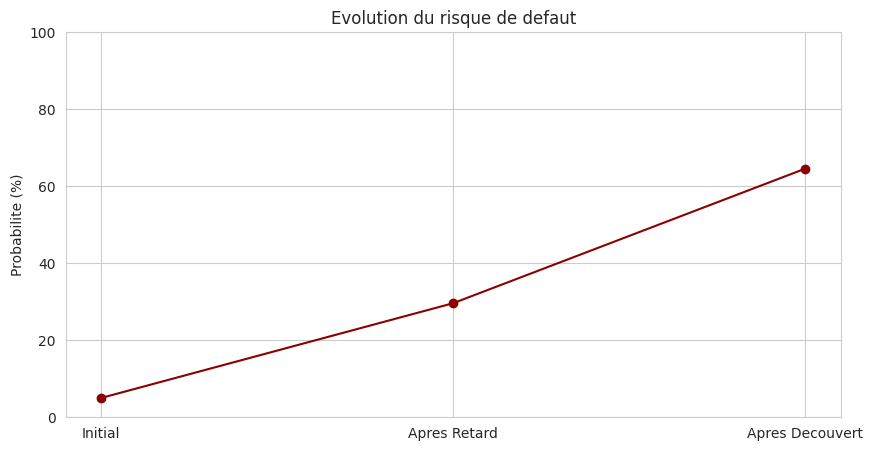

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set_style("whitegrid")

print("="*80)
print("TP PARTIE 2 - THEOREME DE BAYES ET SCORING CREDIT")
print("Mise a jour probabilites risque avec nouvelles informations")
print("="*80)

# ============================================================================
# DONNEES
# ============================================================================

# Taux defaut base et segmentation
taux_defaut_base = 0.05  # 5%

segments = {
    'Premium': {'proportion': 0.30, 'taux_defaut': 0.015},
    'Standard': {'proportion': 0.50, 'taux_defaut': 0.05},
    'Risque': {'proportion': 0.20, 'taux_defaut': 0.15}
}

# Evenements observables (Likelihood)
evenements = {
    'Retard paiement': {
        'P(E|Defaut)': 0.80,
        'P(E|Non-defaut)': 0.10
    },
    'Decouvert >500E': {
        'P(E|Defaut)': 0.65,
        'P(E|Non-defaut)': 0.15
    },
    'Refus credit ailleurs': {
        'P(E|Defaut)': 0.55,
        'P(E|Non-defaut)': 0.08
    }
}

# ============================================================================
# QUESTION 2.1 - CALCUL BAYES MANUEL
# ============================================================================

print("\n" + "="*80)
print("QUESTION 2.1 - CALCUL BAYES MANUEL")
print("="*80)
print("\n- CONTEXTE :")
print("  Client Segment Standard presente un RETARD PAIEMENT")
print(f"  * Prior P(Defaut) = {segments['Standard']['taux_defaut']:.1%}")
print(f"  * P(Retard|Defaut) = {evenements['Retard paiement']['P(E|Defaut)']:.0%}")
print(f"  * P(Retard|Non-defaut) = {evenements['Retard paiement']['P(E|Non-defaut)']:.0%}")

# a) Calcul Bayes
prior = segments['Standard']['taux_defaut']
likelihood_defaut = evenements['Retard paiement']['P(E|Defaut)']
likelihood_non_defaut = evenements['Retard paiement']['P(E|Non-defaut)']

# P(Retard) = P(Retard|Defaut)*P(Defaut) + P(Retard|Non-defaut)*P(Non-defaut)
p_retard = (likelihood_defaut * prior) + (likelihood_non_defaut * (1 - prior))

# P(Defaut|Retard) = P(Retard|Defaut) * P(Defaut) / P(Retard)
posterior = (likelihood_defaut * prior) / p_retard

print(f"\nCALCUL DETAIL BAYES :")
print(f"  Etape 1 : Calcul P(Retard) = {p_retard:.4f} ({p_retard:.2%})")
print(f"  Etape 2 : P(Defaut|Retard) = {posterior:.4f} ({posterior:.2%})")

# b) Decision
if posterior < 0.15:
    decision = "SURVEILLANCE STANDARD"
    action = "Monitoring mensuel"
elif posterior < 0.30:
    decision = "SURVEILLANCE RENFORCEE"
    action = "Monitoring hebdomadaire"
else:
    decision = "RESTRICTION CREDIT"
    action = "Blocage nouveaux credits"

print(f"\nDECISION : {decision}")
print(f"ACTION : {action}")

# ============================================================================
# QUESTION 2.2 - MISE A JOUR SEQUENTIELLE
# ============================================================================

prior_2 = posterior
likelihood_defaut_2 = evenements['Decouvert >500E']['P(E|Defaut)']
likelihood_non_defaut_2 = evenements['Decouvert >500E']['P(E|Non-defaut)']

p_decouvert = (likelihood_defaut_2 * prior_2) + (likelihood_non_defaut_2 * (1 - prior_2))
posterior_2 = (likelihood_defaut_2 * prior_2) / p_decouvert

print("\n" + "="*80)
print("QUESTION 2.2 - MISE A JOUR SEQUENTIELLE")
print("="*80)
print(f"P(Defaut|Retard ET Decouvert) = {posterior_2:.2%}")

# Graphique
etapes = ['Initial', 'Apres Retard', 'Apres Decouvert']
probas = [prior * 100, posterior * 100, posterior_2 * 100]
plt.figure(figsize=(10, 5))
plt.plot(etapes, probas, marker='o', color='darkred')
plt.title('Evolution du risque de defaut')
plt.ylabel('Probabilite (%)')
plt.ylim(0, 100)
plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score, auc,
    precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
)

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("="*80)
print("TP PARTIE 3 — K-NEAREST NEIGHBORS (KNN) ET ÉVALUATION MODÈLE")
print("Classification crédit et optimisation hyperparamètres")
print("="*80)

TP PARTIE 3 — K-NEAREST NEIGHBORS (KNN) ET ÉVALUATION MODÈLE
Classification crédit et optimisation hyperparamètres


In [17]:
# ============================================================================
# QUESTION 3.2 - PREPROCESSING
# ============================================================================

# Séparation Features (X) / Target (y)
X = df_credit.drop('Defaut', axis=1)
y = df_credit['Defaut']

# Split stratifié pour conserver les proportions de classes (13.9% de défaut)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalisation (Essentiel pour KNN car basé sur les distances)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Taille Train set : {X_train.shape[0]} samples")
print(f"Taille Test set : {X_test.shape[0]} samples")
print(f"\nVérification stratification (Taux de défaut) :")
print(f"Train : {y_train.mean():.2%}")
print(f"Test : {y_test.mean():.2%}")

Taille Train set : 700 samples
Taille Test set : 300 samples

Vérification stratification (Taux de défaut) :
Train : 13.86%
Test : 14.00%


In [ ]:
# ============================================================================
# QUESTION 3.3 - OPTIMISATION DU PARAMÈTRE K
# ============================================================================

k_range = range(1, 31)
cv_scores = []

# Validation croisée 5-fold pour chaque K
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # On utilise l'AUC comme métrique pour l'optimisation car les classes sont déséquilibrées
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())

# Identification du meilleur K
best_k = k_range[np.argmax(cv_scores)]
print(f"Meilleur K identifié par validation croisée : {best_k}")
print(f"Score AUC moyen correspondant : {max(cv_scores):.4f}")

# Graphique d'optimisation
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o', linestyle='--', color='blue')
plt.axvline(best_k, color='red', linestyle=':', label=f'Best K = {best_k}')
plt.title("Optimisation du paramètre K (Validation Croisée)")
plt.xlabel("Valeur de K (Voisins)")
plt.ylabel("AUC Score Moyen")
plt.legend()
plt.grid(True)
plt.show()

Aperçu du dataset :
   Age        Revenu         Dette  Score_Interne  Defaut
0   56  10903.305196  10180.891554     543.400033       1
1   69  38051.954538   3801.091443     657.127279       1
2   46  23654.738821   5674.054177     814.954342       0
3   32  13666.194356   7797.772496     335.203491       0
4   60  25301.406736    744.902801     753.608781       0

Taux de défaut global : 13.90%


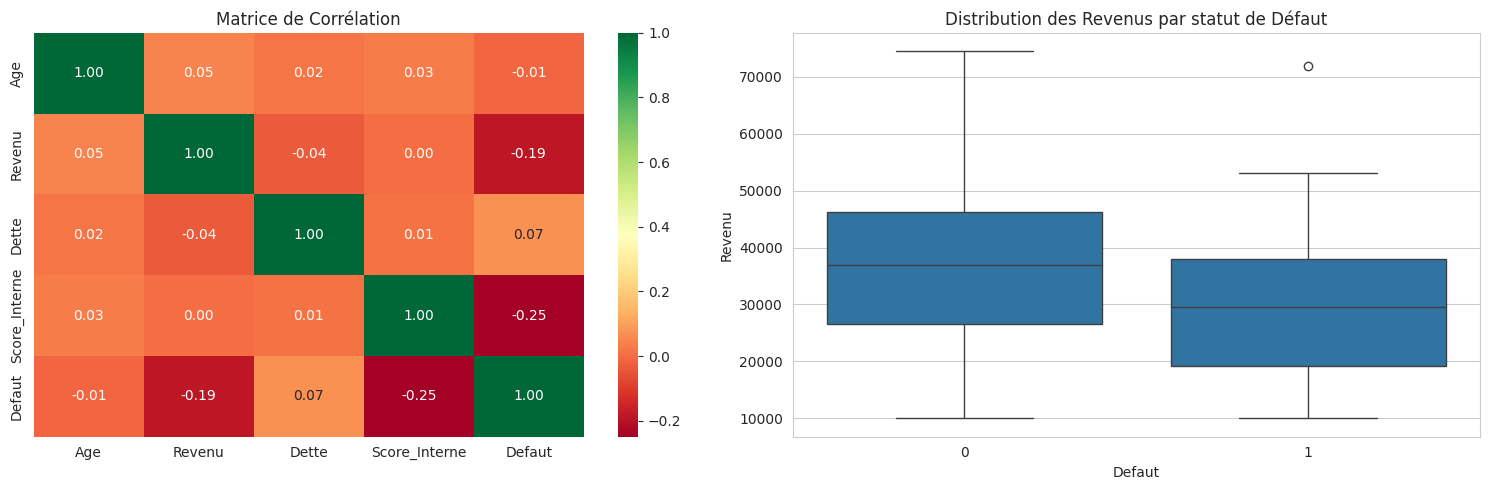

In [16]:
# ============================================================================
# QUESTION 3.1 - EXPLORATION ET GÉNÉRATION DE DONNÉES
# ============================================================================

np.random.seed(42)
n_samples = 1000

# Génération de variables explicatives
age = np.random.randint(18, 70, n_samples)
revenu_annuel = np.random.normal(35000, 15000, n_samples).clip(10000, 150000)
dette_existante = np.random.normal(5000, 3000, n_samples).clip(0, 30000)
score_credit_interne = np.random.uniform(300, 850, n_samples)

# Logique de défaut (Target)
# Le défaut est influencé par le ratio dette/revenu et le score interne
prob = 1 / (1 + np.exp(-(0.0001 * dette_existante - 0.00005 * revenu_annuel - 0.005 * score_credit_interne + 2)))
defaut = (np.random.rand(n_samples) < prob).astype(int)

df_credit = pd.DataFrame({
    'Age': age,
    'Revenu': revenu_annuel,
    'Dette': dette_existante,
    'Score_Interne': score_credit_interne,
    'Defaut': defaut
})

print("Aperçu du dataset :")
print(df_credit.head())
print(f"\nTaux de défaut global : {df_credit['Defaut'].mean():.2%}")

# Visualisations
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 1. Heatmap de corrélation
sns.heatmap(df_credit.corr(), annot=True, cmap='RdYlGn', fmt='.2f', ax=ax[0])
ax[0].set_title("Matrice de Corrélation")

# 2. Boxplot Revenu vs Défaut
sns.boxplot(x='Defaut', y='Revenu', data=df_credit, ax=ax[1])
ax[1].set_title("Distribution des Revenus par statut de Défaut")

plt.tight_layout()
plt.show()